In [1]:
import certifi
import cudf
import cuml
import cupy as cp
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
import time
import yaml

from functools import partial
from math import cos, sin, asin, sqrt, pi
from tqdm import tqdm
from typing import Optional

import dask
import dask.array as da
import dask_cudf

from dask_kubernetes import KubeCluster, make_pod_from_dict
from dask.distributed import Client, WorkerPlugin, wait, progress


class SimpleTimer:
    def __init__(self):
        self.start = None
        self.end = None
        self.elapsed = None

    def __enter__(self):
        self.start = time.perf_counter_ns()
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time.perf_counter_ns()
        self.elapsed = self.end - self.start

        
def create_pod_from_yaml(yaml_file):
    with open(yaml_file, 'r') as reader:
        d = yaml.safe_load(reader)
        d = dask.config.expand_environment_variables(d)
    return make_pod_from_dict(d)


def build_worker_and_scheduler_pods(sched_spec, worker_spec):
    assert os.path.isfile(sched_spec)
    assert os.path.isfile(worker_spec)

    sched_pod = create_pod_from_yaml(sched_spec)
    worker_pod = create_pod_from_yaml(worker_spec)

    return sched_pod, worker_pod


dask.config.set({"kubernetes.scheduler-service-type": "LoadBalancer",
                 "kubernetes.idle-timeout": None,
                 "kubernetes.scheduler-service-wait-timeout": 3600,
                 "kubernetes.deploy-mode": "remote",
                 "distributed.scheduler.idle-timeout": None,
                 "distributed.scheduler.locks.lease-timeout": None,
                 "distributed.comm.timeouts.connect": 3600,
                 "distributed.comm.tls.ca-file": certifi.where()})

sched_pod, worker_pod = build_worker_and_scheduler_pods(sched_spec='./specs/sched-spec.yaml',
                                                        worker_spec='./specs/worker-spec.yaml')

In [2]:
cluster = KubeCluster(pod_template=worker_pod,
                      scheduler_pod_template=sched_pod)

client = Client(cluster)
scheduler_address = cluster.scheduler_address

Creating scheduler pod on cluster. This may take some time.


/home/drobison/anaconda3/envs/rapids-0.18/lib/python3.8/site-packages/distributed/client.py:1133: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | client | scheduler | workers |
+---------+--------+-----------+---------+
| msgpack | 1.0.2  | 1.0.0     | None    |
+---------+--------+-----------+---------+
Notes: 
-  msgpack: Variation is ok, as long as everything is above 0.6
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


In [ ]:
n_workers = 4
cluster.scale(n_workers)

### Helper Tools

In [4]:
def scale_workers(client, n_workers, timeout=300):
    client.cluster.scale(n_workers)
    
    m = len(client.has_what().keys())    
    start = end = time.perf_counter_ns()
    while ((m != n_workers) and (((end - start) / 1e9) < timeout) ):
        time.sleep(5)
        m = len(client.has_what().keys())
        
        end = time.perf_counter_ns()
        
    if (((end - start) / 1e9) >= timeout):
        raise RuntimeError(f"Failed to rescale cluster in {timeout} sec."
              "Try increasing timeout for very large containers, and verify available compute resources.")
        
        
def construct_worker_pool(client, n_workers, auto_scale=False, timeout=300):
    workers = [w for w in client.has_what().keys()]
    if (len(workers) < n_workers):
        if (auto_scale):
            scale_workers(client=client, n_workers=n_workers, timeout=timeout)
            workers = [w for w in client.has_what().keys()]
        else:
            print("Attempt to construct worker pool larger than available worker set, and auto_scale is False."
                  " Returning entire pool.")
    else:
        workers = random.sample(population=workers, k=n_workers)
        
    return workers


def estimate_df_rows(client, files, storage_opts={}, testpct=0.01):
    workers = client.has_what().keys()
    
    est_size = 0
    for file in files:
        if (file.endswith('.csv')):
            df = dask_cudf.read_csv(file, npartitions=len(workers), storage_options=storage_opts)
        elif (file.endswith('.parquet')):
            df = dask_cudf.read_parquet(file, npartitions=len(workers), storage_options=storage_opts)           
        
        # Select only the index column from our subsample
        est_size += (df.sample(frac=testpct).iloc[:,0].shape[0] / testpct).compute()
        del df
    
    return est_size

### Taxi Data Setup

In [6]:
def clean(df_part, remap, must_haves):
    """
    This function performs the various clean up tasks for the data
    and returns the cleaned dataframe.
    """
    tmp = {col:col.strip().lower() for col in list(df_part.columns)}
    df_part = df_part.rename(columns=tmp)
    
    # rename using the supplied mapping
    df_part = df_part.rename(columns=remap)
    
    # iterate through columns in this df partition
    for col in df_part.columns:
        # drop anything not in our expected list
        if col not in must_haves:
            df_part = df_part.drop(col, axis=1)
            continue

        # fixes datetime error found by Ty Mckercher and fixed by Paul Mahler
        if df_part[col].dtype == 'object' and col in ['pickup_datetime', 'dropoff_datetime']:
            df_part[col] = df_part[col].astype('datetime64[ms]')
            continue

        # if column was read as a string, recast as float
        if df_part[col].dtype == 'object':
            df_part[col] = df_part[col].astype('float32')
        else:
            # downcast from 64bit to 32bit types
            # Tesla T4 are faster on 32bit ops
            if 'int' in str(df_part[col].dtype):
                df_part[col] = df_part[col].astype('int32')
            if 'float' in str(df_part[col].dtype):
                df_part[col] = df_part[col].astype('float32')
            df_part[col] = df_part[col].fillna(-1)
            
    return df_part

def coalesce_taxi_data(fraction, random_state):
    base_path = 'gcs://anaconda-public-data/nyc-taxi/csv'

    # list of column names that need to be re-mapped
    remap = {}
    remap['tpep_pickup_datetime'] = 'pickup_datetime'
    remap['tpep_dropoff_datetime'] = 'dropoff_datetime'
    remap['ratecodeid'] = 'rate_code'

    #create a list of columns & dtypes the df must have
    must_haves = {
     'pickup_datetime': 'datetime64[ms]',
     'dropoff_datetime': 'datetime64[ms]',
     'passenger_count': 'int32',
     'trip_distance': 'float32',
     'pickup_longitude': 'float32',
     'pickup_latitude': 'float32',
     'rate_code': 'int32',
     'dropoff_longitude': 'float32',
     'dropoff_latitude': 'float32',
     'fare_amount': 'float32'
    }
    
    # apply a list of filter conditions to throw out records with missing or outlier values
    query_frags = [
        'fare_amount > 0 and fare_amount < 500',
        'passenger_count > 0 and passenger_count < 6',
        'pickup_longitude > -75 and pickup_longitude < -73',
        'dropoff_longitude > -75 and dropoff_longitude < -73',
        'pickup_latitude > 40 and pickup_latitude < 42',
        'dropoff_latitude > 40 and dropoff_latitude < 42'
    ]
    
    
    valid_months_2016 = [str(x).rjust(2, '0') for x in range(1, 7)]
    valid_files_2016 = [f'{base_path}/2016/yellow_tripdata_2016-{month}.csv' for month in valid_months_2016]
    
    df_2014_fractional = dask_cudf.read_csv(f'{base_path}/2014/yellow_*.csv', chunksize=25e6).sample(
        frac=fraction, random_state=random_state)
    df_2014_fractional = clean(df_2014_fractional, remap, must_haves)
    
    df_2015_fractional = dask_cudf.read_csv(f'{base_path}/2015/yellow_*.csv', chunksize=25e6).sample(
        frac=fraction, random_state=random_state)
    df_2015_fractional = clean(df_2015_fractional, remap, must_haves)
    
    df_2016_fractional = dask_cudf.read_csv(valid_files_2016, chunksize=25e6).sample(
        frac=fraction, random_state=random_state)
    df_2016_fractional = clean(df_2016_fractional, remap, must_haves)
    
    df_taxi = dask.dataframe.multi.concat([df_2014_fractional, df_2015_fractional, df_2016_fractional])
    df_taxi = df_taxi.query(' and '.join(query_frags))
    
    return df_taxi

In [7]:
def taxi_csv_data_loader(client, response_dtype=np.float32, fraction=1.0, random_state=0):
    response_id = 'fare_amount'
    workers = client.has_what().keys()
    km_fields = ['passenger_count', 'trip_distance', 'pickup_longitude', 'pickup_latitude', 'rate_code',
                 'dropoff_longitude', 'dropoff_latitude', 'fare_amount']
    
    taxi_df = coalesce_taxi_data(fraction=fraction, random_state=random_state)
    
    taxi_df = taxi_df[km_fields]
    with dask.annotate(workers=set(workers)):
        taxi_df = client.persist(collections=taxi_df)
    
    X = taxi_df[taxi_df.columns.difference([response_id])].astype(np.float32)
    y = taxi_df[response_id].astype(response_dtype)
    
    wait(taxi_df)
    
    return taxi_df, X, y

def taxi_parquet_data_loader(client, response_dtype=np.float32, fraction=1.0, random_state=0):
    # list of column names that need to be re-mapped
    remap = {}
    remap['tpep_pickup_datetime'] = 'pickup_datetime'
    remap['tpep_dropoff_datetime'] = 'dropoff_datetime'
    remap['ratecodeid'] = 'rate_code'

    #create a list of columns & dtypes the df must have
    must_haves = {
     'pickup_datetime': 'datetime64[ms]',
     'dropoff_datetime': 'datetime64[ms]',
     'passenger_count': 'int32',
     'trip_distance': 'float32',
     'pickup_longitude': 'float32',
     'pickup_latitude': 'float32',
     'rate_code': 'int32',
     'dropoff_longitude': 'float32',
     'dropoff_latitude': 'float32',
     'fare_amount': 'float32'
    }

    # apply a list of filter conditions to throw out records with missing or outlier values
    query_frags = [
        'fare_amount > 0 and fare_amount < 500',
        'passenger_count > 0 and passenger_count < 6',
        'pickup_longitude > -75 and pickup_longitude < -73',
        'dropoff_longitude > -75 and dropoff_longitude < -73',
        'pickup_latitude > 40 and pickup_latitude < 42',
        'dropoff_latitude > 40 and dropoff_latitude < 42'
    ]

    workers = client.has_what().keys()
    taxi_parquet_path = "gs://anaconda-public-data/nyc-taxi/nyc.parquet"
    response_id = 'fare_amount'
    fields = ['passenger_count', 'trip_distance', 'pickup_longitude', 'pickup_latitude', 'rate_code',
                 'dropoff_longitude', 'dropoff_latitude', 'fare_amount']
    
    taxi_df = dask_cudf.read_parquet(taxi_parquet_path, npartitions=len(workers))
    taxi_df = clean(taxi_df, remap, must_haves)
    taxi_df = taxi_df.query(' and '.join(query_frags))
    taxi_df = taxi_df[fields]
    
    with dask.annotate(workers=set(workers)):
        taxi_df = client.persist(collections=taxi_df)
    
    wait(taxi_df)

    X = taxi_df[taxi_df.columns.difference([response_id])].astype(np.float32)
    y = taxi_df[response_id].astype(response_dtype)
        
    return taxi_df, X, y

## Performance Validation Code

In [8]:
def record_elapsed_timings_to_df(df, timings, record_template, type, columns, write_to=None):
    records = [dict(record_template, **{"sample_index": i,
                                        "elapsed": elapsed,
                                        "type": type})
                  for i, elapsed in enumerate(timings)]

    df = df.append(other=records, ignore_index=True)
    
    if (write_to):
        df.to_csv(write_to, columns=columns) 
            
    return df


def collect_load_time_samples(load_func, count, return_final_sample=True, verbose=False):
    timings = []
    for m in tqdm(range(count)):
        with SimpleTimer() as timer:
            df, X, y = load_func()
        timings.append(timer.elapsed)
    
    if (return_final_sample):
        return df, X, y, timings
    
    return None, None, None, timings


def collect_func_time_samples(func, count, verbose=False):
    timings = []
    for k in tqdm(range(count)):
        with SimpleTimer() as timer:
            func()
        timings.append(timer.elapsed)
        
    return timings


def sweep_fit_func(model, func_id, require_compute, X, y, xy_fit, count):
    _fit_func_attr = getattr(model, func_id)
    if (require_compute):
        if (xy_fit):
            fit_func = partial(lambda X, y: _fit_func_attr(X, y).compute(), X, y)
        else:
            fit_func = partial(lambda X: _fit_func_attr(X).compute(), X)
    else:
        if (xy_fit):
            fit_func = partial(_fit_func_attr, X, y)
        else:
            fit_func = partial(_fit_func_attr, X)                

    return collect_func_time_samples(func=fit_func, count=count)


def sweep_predict_func(model, func_id, require_compute, X, count):
    _predict_func_attr = getattr(model, func_id)
    predict_func = partial(lambda X: _predict_func_attr(X).compute(), X)
    
    return collect_func_time_samples(func=predict_func, count=count)
    

def performance_sweep(client, model, data_loader, hardware_type, worker_counts=[1], samples=1, load_samples=1, max_data_frac=1.0,
                    predict_frac=0.05, scaling_type='weak', xy_fit=True, fit_requires_compute=False, update_workers_in_kwargs=True,
                    response_dtype=np.float32, out_path='./perf_sweep.csv', append_to_existing=False, model_name=None,
                    fit_func_id="fit", predict_func_id="predict", scaling_denom=None, model_args={}, model_kwargs={}):
    """
    Primary performance sweep entrypoint.
    
    
    Parameters
    ------------
    client: DASK client associated with the cluster we're interesting in collecting performance data for.
    
    model: Model object on which to gather performance data. This will be created and destroyed,
        once for each element of 'worker_counts'
    
    data_loader: arbitrary data loading function that will be called to load the appropriate testing data.
        Function that is responsible for loading and returning the data to be used for a given performance run. Function
        signature must accept (client, fraction, and random_state). Client should be used to distribute data, and loaders
        should utilize fraction and random_state with dask's dataframe.sample method to allow for control of how much data
        is loaded.
        
        When called, its return value should be of the form: df, X, y, where df is the full dask_cudf dataframe, X is a
        dask_cudf dataframe which contains all explanatory variables that will be passed to the 'fit' function, and y is a
        dask_cudf series or dataframe that contains response variables which should be passed to fit/predict as fit(X, y)
    
    hardware_type: indicates the core hardware the current sweep is running on. ex. 'T4', 'V100', 'A100'
    
    worker_counts: List indicating the number of workers that should be swept. Ex [1, 2, 4]
        worker counts must fit within the cluster associated with 'client', if the current DASK worker count is different
        from what is requested on a given sweep, attempt to automatically scale the worker count. NOTE: this does not 
        mean we will scale the available cluster nodes, just the number of deployed worker pods.
    
    samples: number of fit/predict samples to record per worker count
    
    load_samples: number of times to sample data loads. This effectively times how long 'data_loader' runs.
    
    max_data_frac: maximum fraction of data to return.
        Strong scaling: each run will utilize max_data_frac data.
        Weak scaling: each run will utilize (current worker count) / (max worker count) * max_data_frac data.
        
    predict_frac: fraction of training data used to test inference
    
    scaling_type: values can be 'weak' or 'strong' indicating the type of scaling sweep to perform.
    
    xy_fit: indicates whether or not the model's 'fit' function is of the form (X, y), when xy_fit is False, we assume that
        fit is of the form (X), as is the case with various unsupervised methods ex. KNN.
    
    fit_requires_compute: False generally, set this to True if the model's 'fit' function requires a corresponding '.compute()'
        call to execute the required work.
    
    update_workers_in_kwargs: Some algorithms accept a 'workers' list, much like DASK, and will require their kwargs to have
        workers populated. Setting this flag handles this automatically.
        
    response_dtype: defaults to np.float32, some algorithms require another dtype, such as int32
    
    out_path: path where performance data csv should be saved
    
    append_to_existing: When true, append results to an existing csv, otherwise overwrite.
    
    model_name: Override what we output as the model name
    
    fit_func_id: Defaults to 'fit', only set this if the model has a non-standard naming.
    
    predict_func_id: Defaults to 'predict', only set this if the model has a on-standard predict naming.
    
    scaling_denom: (weak scaling) defaults to max(workers) if unset. Specifies the maximum worker count that weak scaling
        should scale against. For example, when using 1 worker in a weak scaling sweep, the worker will attempt to
        process a fraction of the total data equal to 1/scaling_denom
    
    model_args: args that will be passed to the model's constructor
    
    model_kwargs: keyword args that will be passed to the model's constructor

    Returns
    --------
    
    """
    
    cols = ['n_workers', 'sample_index', 'elapsed', 'type', 'algorithm', 'scaling_type', 'data_fraction', 'hardware']
    perf_df = cudf.DataFrame(columns=cols)
    if (append_to_existing):
        try:
            perf_df = cudf.read_csv(out_path)
        except:
            pass
    
    model_name = model_name if model_name else str(model)
    scaling_denom = scaling_denom if (scaling_denom is not None) else max(worker_counts)
    max_data_frac = min(1.0, max_data_frac)

    start_msg = f"Starting {scaling_type}-scaling performance sweep for:\n"
    start_msg += f" model      : {model_name}\n"
    start_msg += f" data loader: {data_loader}.\n"
    start_msg += f"Configuration\n"
    start_msg += "==========================\n"
    start_msg += f"{'Worker counts':<25} : {worker_counts}\n"
    start_msg += f"{'Fit/Predict samples':<25} : {samples}\n"
    start_msg += f"{'Data load samples':<25} : {load_samples}\n"
    start_msg += f"- {'Max data fraction':<23} : {max_data_frac}\n"
    start_msg += f"{'Model fit':<25} : {'X ~ y' if xy_fit else 'X'}\n"
    start_msg += f"- {'Response DType':<23} : {response_dtype}\n"
    start_msg += f"{'Writing results to':<25} : {out_path}\n"
    start_msg += f"- {'Method':<23} : {'overwrite' if not append_to_existing else 'append'}\n"
    print(start_msg, flush=True)
    
    for n in worker_counts:        
        fraction = (n / scaling_denom) * max_data_frac if scaling_type == 'weak' else max_data_frac
        record_template = {"n_workers": n, "type": "predict", "algorithm": model_name,
               "scaling_type": scaling_type, "data_fraction": fraction, "hardware": hardware_type}
        scale_workers(client, n)

        print(f"Sampling <{load_samples}> load times with {n} workers.", flush=True)
        
        load_func = partial(data_loader, client=client, response_dtype=response_dtype, fraction=fraction, random_state=0)
        df, X, y, load_timings = collect_load_time_samples(load_func=load_func, count=load_samples)
        
        perf_df = record_elapsed_timings_to_df(df=perf_df, timings=load_timings, type='load',
                                                    record_template=record_template, columns=cols, write_to=out_path)

        print(f"Finished loading <{load_samples}>, samples, to <{n}> workers with a mean time of {np.mean(load_timings)/1e9:0.4f} sec.", flush=True)
        print(f"Sweeping {model_name} '{fit_func_id}' with <{n}> workers. Sampling <{samples}> times.", flush=True)

        if (update_workers_in_kwargs and 'workers' in model_kwargs):
            model_kwargs['workers'] = workers = client.has_what().keys()
    
        m = model(*model_args, **model_kwargs)
        if (fit_func_id):
            fit_timings = sweep_fit_func(model=m, func_id=fit_func_id,
                                             require_compute=fit_requires_compute,
                                             X=X, y=y, xy_fit=xy_fit, count=samples)

            perf_df = record_elapsed_timings_to_df(df=perf_df, timings=fit_timings, type='fit',
                                                        record_template=record_template, columns=cols, write_to=out_path)

            print(f"Finished gathering <{samples}>, 'fit' samples using <{n}> workers, with a mean time of {np.mean(fit_timings)/1e9:0.4f} sec.",
                  flush=True)
        else:
            print(f"Skipping fit sweep, fit_func_id is None")

        if (predict_func_id):
            print(f"Sweeping {model_name} '{predict_func_id}' with <{n}> workers. Sampling <{samples}> times.", flush=True)
            predict_timings = sweep_predict_func(model=m, func_id=predict_func_id,
                                                     require_compute=True, X=X, count=samples)

            perf_df = record_elapsed_timings_to_df(df=perf_df, timings=predict_timings, type='predict',
                                                        record_template=record_template, columns=cols, write_to=out_path)
            
            print(f"Finished gathering <{samples}>, 'predict' samples using <{n}> workers, with a mean time of {np.mean(predict_timings)/1e9:0.4f} sec.",
                  flush=True)
        else:
            print(f"Skipping inference sweep. predict_func_id is None")

### Vis and Analysis

In [9]:
def simple_ci(df, fields, groupby):
    gbdf = df[fields].groupby(groupby).agg(['mean', 'std', 'count'])   
    
    ci = (1.96 + gbdf['elapsed']['std'] / np.sqrt(gbdf['elapsed']['count']))
    
    ci_df = ci.reset_index()
    ci_df['ci.low'] = gbdf['elapsed'].reset_index()['mean'] - ci_df[0]
    ci_df['ci.high'] = gbdf['elapsed'].reset_index()['mean'] + ci_df[0]
    
    return ci_df

def visualize_csv_data(csv_path):
    df = cudf.read_csv(csv_path)
    
    fields = ['elapsed', 'elapsed_sec', 'type', 'n_workers', 'hardware', 'scaling_type']
    groupby = ['n_workers', 'type', 'hardware', 'scaling_type']
    df['elapsed_sec'] = df['elapsed']/1e9

    ci_df = simple_ci(df, fields, groupby=groupby)

    # Rescale to seconds
    ci_df[['ci.low', 'ci.high']] = ci_df[['ci.low', 'ci.high']]/1e9

    # Print confidence intervals
    print(ci_df[['hardware', 'n_workers', 'type', 'ci.low', 'ci.high']][ci_df['type'] != 'load'])

    sns.set_theme(style="whitegrid")
    sns.set(rc={'figure.figsize':(20, 10)}, font_scale=2)

    # Boxplots for elapsed time at each worker count.
    plot_df = df[fields][df[fields].type != 'load'].to_pandas()
    ax = sns.catplot(data=plot_df, x="n_workers", y="elapsed_sec",
                     col="type", row="scaling_type", hue="hardware", kind="box",
                     height=8, order=None)

### Higgs Data Configuration (small)

In [15]:
## Run to configure for HIGGS dataset.
preload_data = False
append_to_existing = True
samples = 5
load_samples = 1
worker_counts = [1]
scaling_denom = 8 #max(worker_counts)
hardware_type = None
data_loader = None
max_data_frac = 1.0
scale_type = 'weak'
out_prefix = 'higgs'

if (not hardware_type):
    raise RuntimeError("Please specify the hardware type for this run! ex. (T4, V100, A100)")
    
if (not preload_data):
    data_loader = higgs_data_loader
else:
    data = higgs_data_loader(client, fraction=max_data_frac)
    data_loader = lambda client, response_dtype, fraction, random_state: data
    
if (not hardware_type):
    raise RuntimeError("Please specify the hardware type for this run! ex. (T4, V100, A100)")

sweep_kwargs = {
    'append_to_existing': append_to_existing,
    'samples': samples,
    'load_samples': load_samples,
    'worker_counts': worker_counts,
    'scaling_denom': scaling_denom,
    'hardware_type': hardware_type,
    'data_loader': data_loader,
    'max_data_frac': max_data_frac,
    'scaling_type': scale_type
}

higgs_gcp_path = "gs://dvn-cloudml-examples/HIGGS.csv"
higgs_storage_opts = {'token': "/etc/secrets/keyfile.json"}

In [11]:
estimated_rows = estimate_df_rows(client, files=[higgs_gcp_path], storage_opts=higgs_storage_opts, testpct=0.001)
print(int(estimated_rows))

10986000


### Taxi Data Configuration (Medium)
We can use the parquet data from the anaconda public repo here. Which will illustrate how much faster it is to read parquet, and gives us around 150 million rows of data to work with.

In [ ]:
# Uncomment to test with Taxi Dataset
preload_data = False
append_to_existing = True
samples = 5
load_samples = 1
worker_counts = [8]
scaling_denom = 8
hardware_type = None
max_data_frac = 1.0
scale_type = 'weak' # weak | strong
out_prefix = 'taxi_medium'

if (not preload_data):
    data_loader = taxi_parquet_data_loader
else:
    data = taxi_parquet_data_loader(client, fraction=max_data_frac)
    data_loader = lambda client, response_dtype, fraction, random_state: data
    
if (not hardware_type):
    raise RuntimeError("Please specify the hardware type for this run! ex. (T4, V100, A100)")

sweep_kwargs = {
    'append_to_existing': append_to_existing,
    'samples': samples,
    'load_samples': load_samples,
    'worker_counts': worker_counts,
    'scaling_denom': scaling_denom,
    'hardware_type': hardware_type,
    'data_loader': data_loader,
    'max_data_frac': max_data_frac,
    'scaling_type': scale_type
}

In [ ]:
taxi_parquet_path = ["gs://anaconda-public-data/nyc-taxi/nyc.parquet"]
estimated_rows = estimate_df_rows(client, files=taxi_parquet_path, testpct=0.0001)
print(estimated_rows)

## Taxi Data Configuration (Large)
The largest dataset we'll work with, contains up to 450 million rows of taxi data, stored as CSV files.

In [ ]:
# Uncomment to sweep with the large Taxi Dataset
preload_data = True
append_to_existing = True
samples = 5
load_samples = 1
worker_counts = [8]
scaling_denom = 8
hardware_type = None
data_loader = taxi_csv_data_loader
max_data_frac = 1.0
scale_type = 'weak'
out_prefix = 'taxi_large'


if (not preload_data):
    data_loader = taxi_csv_data_loader
else:
    data = taxi_csv_data_loader(client, fraction=max_data_frac)
    data_loader = lambda client, response_dtype, fraction, random_state: data

if (not hardware_type):
    raise RuntimeError("Please specify the hardware type for this run! ex. (T4, V100, A100)")

sweep_kwargs = {
    'append_to_existing': append_to_existing,
    'samples': samples,
    'load_samples': load_samples,
    'worker_counts': worker_counts,
    'scaling_denom': scaling_denom,
    'hardware_type': hardware_type,
    'data_loader': data_loader,
    'max_data_frac': max_data_frac,
    'scaling_type': scale_type
}

# ETL Exploration CSV vs Parquet

In [ ]:
remap = {}
remap['tpep_pickup_datetime'] = 'pickup_datetime'
remap['tpep_dropoff_datetime'] = 'dropoff_datetime'
remap['ratecodeid'] = 'rate_code'

#create a list of columns & dtypes the df must have
must_haves = {
 'pickup_datetime': 'datetime64[ms]',
 'dropoff_datetime': 'datetime64[ms]',
 'passenger_count': 'int32',
 'trip_distance': 'float32',
 'pickup_longitude': 'float32',
 'pickup_latitude': 'float32',
 'rate_code': 'int32',
 'dropoff_longitude': 'float32',
 'dropoff_latitude': 'float32',
 'fare_amount': 'float32'
}

# apply a list of filter conditions to throw out records with missing or outlier values
query_frags = [
    'fare_amount > 0 and fare_amount < 500',
    'passenger_count > 0 and passenger_count < 6',
    'pickup_longitude > -75 and pickup_longitude < -73',
    'dropoff_longitude > -75 and dropoff_longitude < -73',
    'pickup_latitude > 40 and pickup_latitude < 42',
    'dropoff_latitude > 40 and dropoff_latitude < 42'
]

workers = client.has_what().keys()

In [ ]:
base_path = 'gcs://anaconda-public-data/nyc-taxi/csv'

with SimpleTimer() as timer_csv:
    df_csv_2014 = dask_cudf.read_csv(f'{base_path}/2014/yellow_*.csv', chunksize=25e6)
    df_csv_2014 = clean(df_csv_2014, remap, must_haves)
    df_csv_2014 = df_csv_2014.query(' and '.join(query_frags))
    
    with dask.annotate(workers=set(workers)):
        df_csv_2014 = client.persist(collections=df_csv_2014)
        
    wait(df_csv_2014)

print(df_csv_2014.columns)
rows_csv = df_csv_2014.iloc[:,0].shape[0].compute()
print(f"CSV load took {timer_csv.elapsed/1e9} sec. For {rows_csv} rows of data => {rows_csv/(timer_csv.elapsed/1e9)} rows/sec")

In [ ]:
client.cancel(df_csv_2014)

In [ ]:
with SimpleTimer() as timer_parquet:
    df_parquet = dask_cudf.read_parquet(f'gs://anaconda-public-data/nyc-taxi/nyc.parquet', chunksize=25e6)
    df_parquet = clean(df_parquet, remap, must_haves)
    df_parquet = df_parquet.query(' and '.join(query_frags))
    
    with dask.annotate(workers=set(workers)):
        df_parquet = client.persist(collections=df_parquet)
    
    wait(df_parquet)

print(df_parquet.columns)
rows_parquet = df_parquet.iloc[:,0].shape[0].compute()
print(f"Parquet load took {timer_parquet.elapsed/1e9} sec. For {rows_parquet} rows of data => {rows_parquet/(timer_parquet.elapsed/1e9)} rows/sec")

In [ ]:
client.cancel(df_parquet)

Speedup with 8 T4 nodes should be approximately 3-5x

In [ ]:
speedup = (rows_parquet/(timer_parquet.elapsed/1e9))/(rows_csv/(timer_csv.elapsed/1e9))
print(speedup)

# cuML Algorithms -- Performance Sweeps

### RandomForestRegressor

In [16]:
from cuml.dask.ensemble import RandomForestRegressor

rf_kwargs = {
    "workers": client.has_what().keys(),
    "n_estimators": 10,
    "max_depth": 12
}
rf_csv_path = f"./{out_prefix}_random_forest_regression.csv"

performance_sweep(client=client, model=RandomForestRegressor,
                **sweep_kwargs,
                out_path=rf_csv_path,
                response_dtype=np.int32,
                model_kwargs=rf_kwargs)

Starting weak-scaling performance sweep for:
 model      : <class 'cuml.dask.ensemble.randomforestregressor.RandomForestRegressor'>
 data loader: <function higgs_data_loader at 0x7f92ee005040>.
Configuration
Worker counts             : [1]
Fit/Predict samples       : 5
Data load samples         : 1
- Max data fraction       : 1.0
Model fit                 : X ~ y
- Response DType          : <class 'numpy.int32'>
Writing results to        : ./higgs_random_forest_regression.csv
- Method                  : append

Sampling <1> load times with 1 workers.


  0%|          | 0/1 [00:00<?, ?it/s]

Calling higgs data loader


100%|██████████| 1/1 [01:59<00:00, 119.75s/it]

Finished loading <1>, samples, to <1> workers with a mean time of 119.7447 sec.
Benchmarking <class 'cuml.dask.ensemble.randomforestregressor.RandomForestRegressor'> 'fit' with <1> workers. Sampling <5> times.



100%|██████████| 5/5 [00:06<00:00,  1.20s/it]

Finished gathering <5>, 'fit' samples using <1> workers, with a mean time of 1.2041 sec.
Benchmarking <class 'cuml.dask.ensemble.randomforestregressor.RandomForestRegressor'> 'predict' with <1> workers. Sampling <5> times.



100%|██████████| 5/5 [00:07<00:00,  1.44s/it]

Finished gathering <5>, 'predict' samples using <1> workers, with a mean time of 1.4353 sec.


   hardware  n_workers     type    ci.low   ci.high
0        T4          1      fit  1.188620  1.219585
2        T4          1  predict  1.387742  1.482805
3        T4          2      fit  0.837270  0.965195
5        T4          2  predict  1.311119  1.634463
6        T4          4      fit  0.577832  0.672978
8        T4          4  predict  1.448748  2.021556
9        T4          8      fit  0.581886  0.690098
11       T4          8  predict  1.640393  2.160209


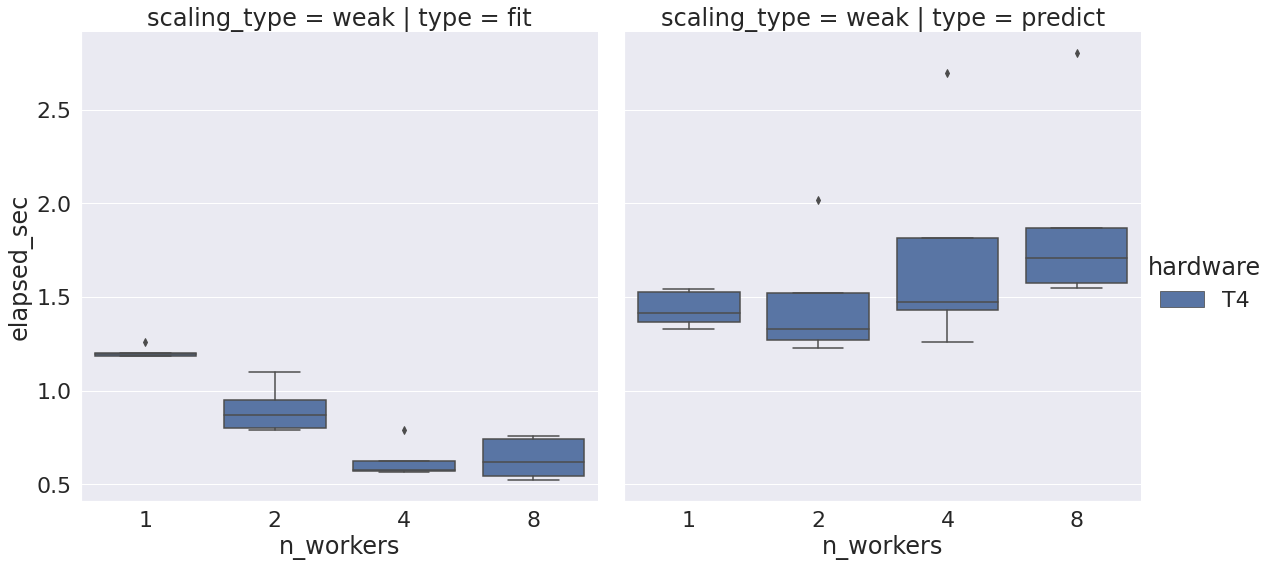

In [17]:
rf_csv_path = f"./{out_prefix}_random_forest_regression.csv"
visualize_csv_data(rf_csv_path)

### KMeans

In [37]:
from cuml.dask.cluster import KMeans

kmeans_kwargs = {
    "client": client,
    "n_clusters": 12,
    "max_iter": 371,
    "tol": 1e-5,
    "oversampling_factor": 3,
    "max_samples_per_batch": 32768/2,
    "verbose": False,
    "init": 'random'
}
kmeans_csv_path = f'./{out_prefix}_kmeans.csv'

performance_sweep(client=client, model=KMeans,
                **sweep_kwargs,
                out_path=kmeans_csv_path,
                xy_fit=False,
                model_kwargs=kmeans_kwargs)

Starting weak-scaling performance sweep for:
 model      : <class 'cuml.dask.cluster.kmeans.KMeans'>
 data loader: <function higgs_data_loader at 0x7f9ab4c36040>.
Configuration
Worker counts             : [2]
Fit/Predict samples       : 5
Data load samples         : 1
- Max data fraction       : 1.0
Model fit                 : X
- Response DType          : <class 'numpy.float32'>
Writing results to        : ./higgs_kmeans.csv
- Method                  : append

Sampling <1> load times with 2 workers.


  0%|          | 0/1 [00:00<?, ?it/s]

Calling higgs data loader


100%|██████████| 1/1 [01:12<00:00, 72.92s/it]

Finished loading <1>, samples, to <2> workers with a mean time of 72.9194 sec.
Benchmarking <class 'cuml.dask.cluster.kmeans.KMeans'> 'fit' with <2> workers. Sampling <5> times.



100%|██████████| 5/5 [00:05<00:00,  1.18s/it]

Finished gathering <5>, 'fit' samples using <2> workers, with a mean time of 1.1793 sec.
Benchmarking <class 'cuml.dask.cluster.kmeans.KMeans'> 'predict' with <2> workers. Sampling <5> times.



100%|██████████| 5/5 [00:05<00:00,  1.16s/it]

Finished gathering <5>, 'predict' samples using <2> workers, with a mean time of 1.1546 sec.


   n_workers     type    ci.low   ci.high
0          2      fit  1.117720  1.240797
2          2  predict  1.041604  1.267688


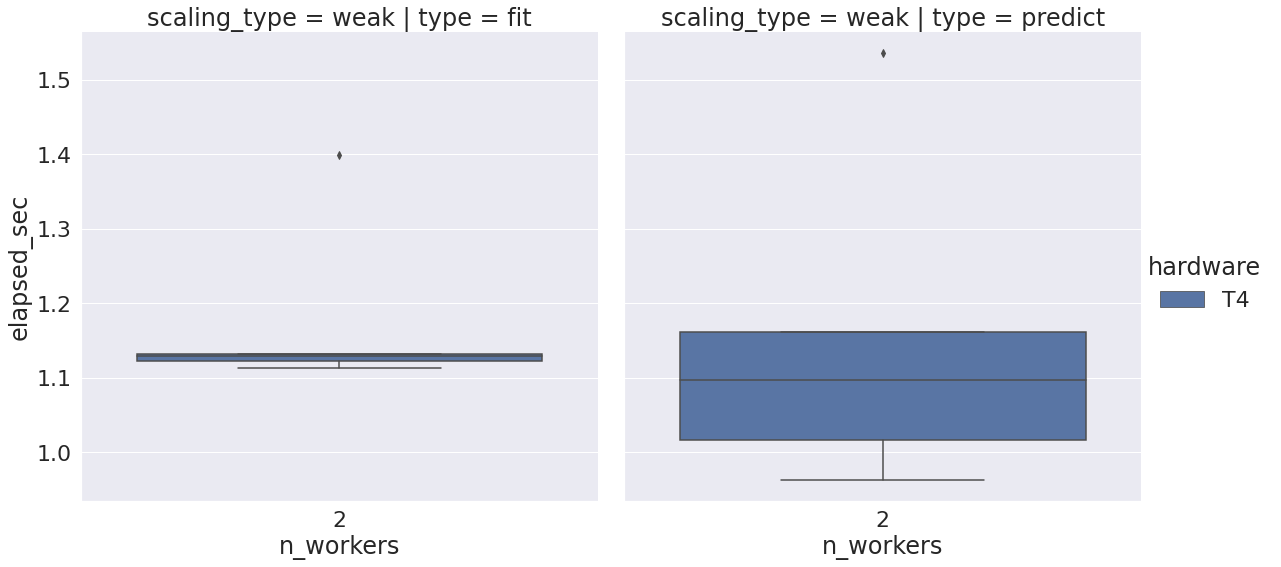

In [39]:
visualize_csv_data(kmeans_csv_path)

### Nearest Neighbors

In [ ]:
from cuml.dask.neighbors import NearestNeighbors

nn_kwargs = {}
nn_csv_path = f'./{out_prefix}_nn.csv'

performance_sweep(client=client, model=NearestNeighbors,
                **sweep_kwargs,
                out_path=nn_csv_path,
                xy_fit=False,
                predict_func_id='get_neighbors',
                model_kwargs=nn_kwargs)

   n_workers     type     ci.low    ci.high
0          8      fit   0.049872   0.131898
1          8      fit   0.034415   0.336251
4          8  predict  32.004380  39.327223
5          8  predict  42.276230  51.382289


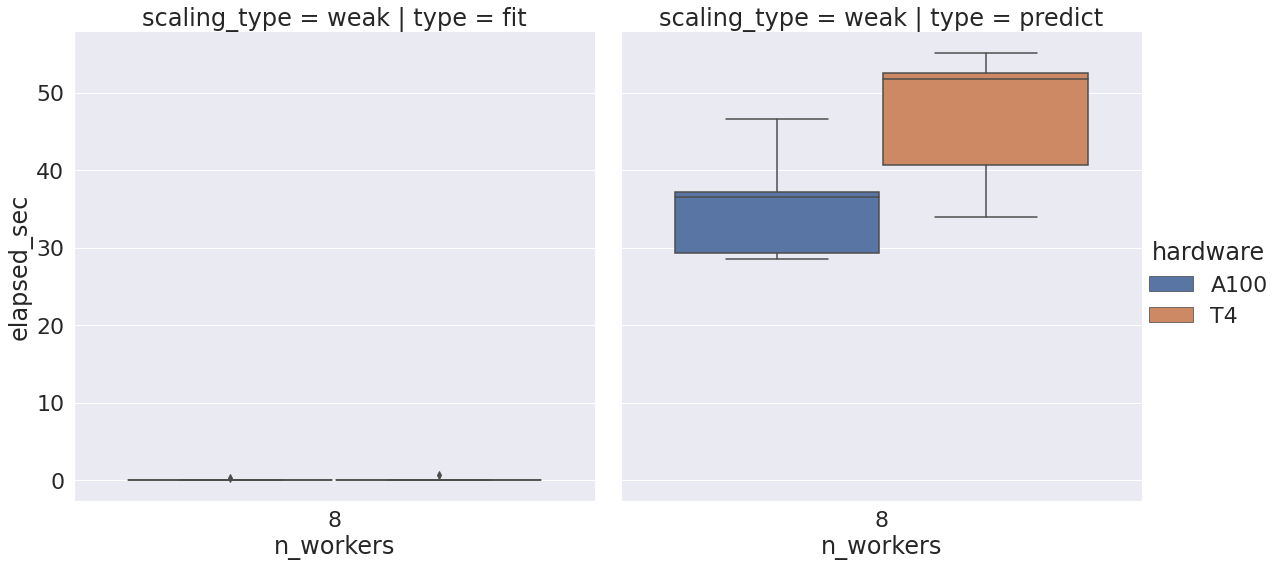

In [10]:
nn_csv_path = f'./{out_prefix}_nn.csv'
visualize_csv_data(nn_csv_path)

### PCA

In [ ]:
from cuml.dask.decomposition import PCA

pca_kwargs = {
    "client": client,
    "n_components": 5,
    "whiten": False
}
pca_csv_path = f'./{out_prefix}_pca.csv'

performance_sweep(client=client, model=PCA,
                **sweep_kwargs,
                out_path=pca_csv_path,
                xy_fit=False,
                fit_requires_compute=True,
                fit_func_id="fit_transform",
                predict_func_id=None, # PCA has no 'predict' method.
                model_kwargs=pca_kwargs)

In [ ]:
visualize_csv_data(pca_csv_path)

### TruncatedSVD

In [ ]:
from cuml.dask.decomposition import TruncatedSVD

tsvd_kwargs = {
    "client": client,
    "n_components": 5
}
tsvd_csv_path = f'./{out_prefix}_tsvd.csv'

performance_sweep(client=client, model=TruncatedSVD,
                **sweep_kwargs,
                out_path=tsvd_csv_path,
                xy_fit=False,
                fit_requires_compute=True,
                fit_func_id="fit_transform",
                predict_func_id=None,
                model_kwargs=tsvd_kwargs)

In [ ]:
visualize_csv_data(tsvd_csv_path)

### Linear Regression

In [ ]:
from cuml.dask.linear_model import LinearRegression

lr_kwargs = {
    "client": client,
    "algorithm": "eig"
}

lr_csv_path = f'./{out_prefix}_linear_regression.csv'

performance_sweep(client=client, model=LinearRegression,
                **sweep_kwargs,
                out_path=lr_csv_path,
                model_kwargs=lr_kwargs)

In [ ]:
visualize_csv_data(lr_csv_path)

### Ridge Regression

In [ ]:
from cuml.dask.linear_model import Ridge as RidgeRegression

ridge_kwargs = {
    "client": client,
    "solver": "eig"
}

ridge_csv_path = f'./{out_prefix}_ridge_regression.csv'

performance_sweep(client=client, model=RidgeRegression,
                **sweep_kwargs,
                out_path=ridge_csv_path,
                model_kwargs=ridge_kwargs)

In [ ]:
visualize_csv_data(ridge_csv_path)

### Lasso Regression

In [ ]:
from cuml.dask.linear_model import Lasso as LassoRegression

lasso_kwargs = {
    "client": client
}

lasso_csv_path = f'./{out_prefix}_lasso_regression.csv'

performance_sweep(client=client, model=LassoRegression,
                **sweep_kwargs,
                out_path=lasso_csv_path,
                model_kwargs=lasso_kwargs)

In [ ]:
visualize_csv_data(lasso_csv_path)

### ElasticNet Regression

In [ ]:
from cuml.dask.linear_model import ElasticNet as ElasticNetRegression

elastic_kwargs = {
    "client": client,
}

enr_csv_path = f'./{out_prefix}_elastic_regression.csv'

performance_sweep(client=client, model=ElasticNetRegression,
                **sweep_kwargs,
                out_path=enr_csv_path,
                model_kwargs=elastic_kwargs)

In [ ]:
visualize_csv_data(enr_csv_path)

### Model Parallel Multi-GPU Linear Regression

In [ ]:
from cuml.dask.solvers import CD

cd_kwargs = {
}

cd_csv_path = f'./{out_prefix}_mutli_gpu_linear_regression.csv'

performance_sweep(client=client, model=CD,
                **sweep_kwargs,
                out_path=cd_csv_path,
                model_kwargs=cd_kwargs)

In [ ]:
visualize_csv_data(cd_csv_path)

### XGBoost

In [35]:
import xgboost as xgb

xg_args = [client]
xg_kwargs = {
    'params': {
        'tree_method': 'gpu_hist',
    },
    'num_boost_round': 100
}

xgb_csv_path = f'./{out_prefix}_xgb.csv'

class XGBProxy():
    """
    Create a simple API wrapper around XGBoost so that it supports the fit/predict workflow.
    
    Parameters
    -------------
    data_loader: data loader object intended to be used by the performance sweep.
    """
    def __init__(self, data_loader):
        self.args = []
        self.kwargs = {}
        self.data_loader = data_loader
        self.trained_model = None
        
    def loader(self, client, response_dtype, fraction, random_state):
        """
        Wrap the data loader method so that it creates a DMatrix from the returned data.
        """
        df, X, y = self.data_loader(client, response_dtype, fraction, random_state)
        dmatrix = xgb.dask.DaskDMatrix(client, X, y)
        
        return dmatrix, dmatrix, dmatrix

    def __call__(self, *args, **kwargs):
        """
        Acts as a pseudo init function which initializes our model args.
        """
        self.args = args
        self.kwargs = kwargs
        
        return self
        
    def fit(self, X):
        """
        Wrap dask.train, and store the model on our proxy object.
        """
        if (self.trained_model):
            del self.trained_model
            
        self.trained_model = xgb.dask.train(*self.args,
                              dtrain=X,
                              evals=[(X, 'train')],
                              **self.kwargs)
        return self
    
    def predict(self, X):
        assert(self.trained_model)
        
        return xgb.dask.predict(*self.args, self.trained_model, X)
    

xgb_proxy = XGBProxy(data_loader)
performance_sweep(client=client, model=xgb_proxy, data_loader=xgb_proxy.loader, hardware_type=hardware_type,
                worker_counts=worker_counts, 
                samples=samples,
                load_samples=load_samples,
                max_data_frac=max_data_frac, 
                scaling_type=scale_type,
                out_path=xgb_csv_path,
                append_to_existing=append_to_existing,
                update_workers_in_kwargs=False,
                xy_fit=False,
                scaling_denom = scaling_denom,
                model_args=xg_args,
                model_kwargs=xg_kwargs)

Starting weak-scaling performance sweep for:
 model      : <__main__.XGBProxy object at 0x7f9ab553dbe0>
 data loader: <bound method XGBProxy.loader of <__main__.XGBProxy object at 0x7f9ab553dbe0>>.
Configuration
Worker counts             : [2]
Fit/Predict samples       : 5
Data load samples         : 1
- Max data fraction       : 1.0
Model fit                 : X
- Response DType          : <class 'numpy.float32'>
Writing results to        : ./higgs_xgb.csv
- Method                  : append

Sampling <1> load times with 2 workers.


  0%|          | 0/1 [00:00<?, ?it/s]

Calling higgs data loader


100%|██████████| 1/1 [01:02<00:00, 62.32s/it]

Finished loading <1>, samples, to <2> workers with a mean time of 62.3215 sec.
Benchmarking <__main__.XGBProxy object at 0x7f9ab553dbe0> 'fit' with <2> workers. Sampling <5> times.



100%|██████████| 5/5 [00:31<00:00,  6.25s/it]

Finished gathering <5>, 'fit' samples using <2> workers, with a mean time of 6.2493 sec.
Benchmarking <__main__.XGBProxy object at 0x7f9ab553dbe0> 'predict' with <2> workers. Sampling <5> times.



100%|██████████| 5/5 [00:29<00:00,  5.82s/it]

Finished gathering <5>, 'predict' samples using <2> workers, with a mean time of 5.8213 sec.


   n_workers     type     ci.low    ci.high
0          2      fit  19.366278  19.498616
2          2  predict  15.728562  18.202724


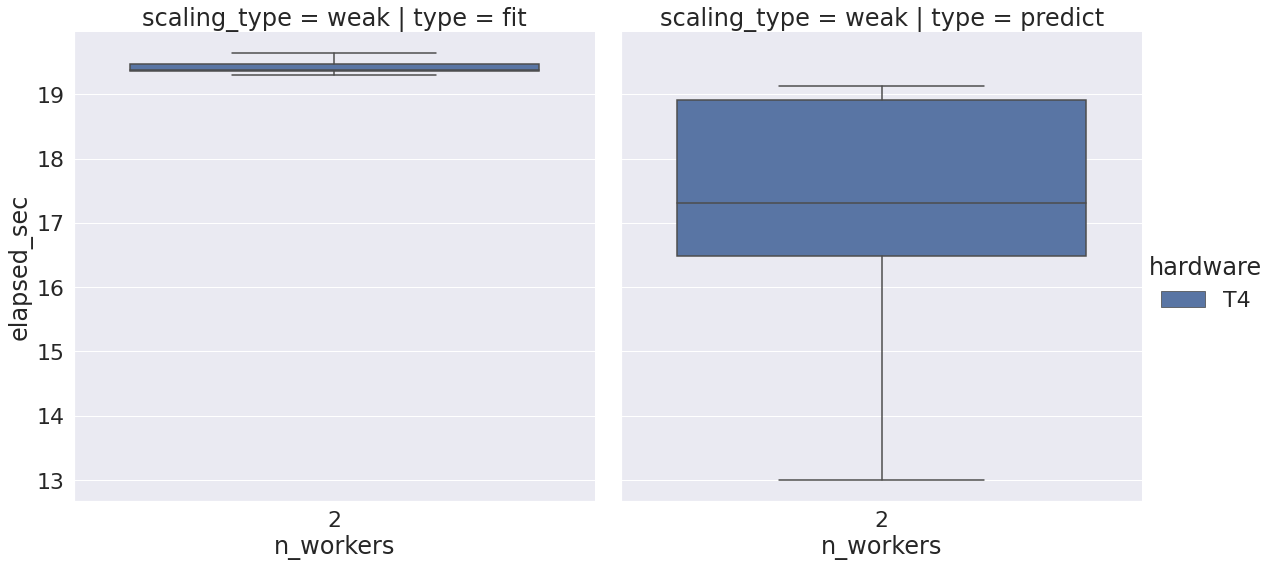

In [32]:
visualize_csv_data(xgb_csv_path)